# Set Environment & Globals

In [1]:
%load_ext jupyter_black

# base
import os
import sys
import warnings
import logging
from tqdm import tqdm

logging.basicConfig(level="INFO")
warnings.simplefilter("ignore", FutureWarning)
warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", RuntimeWarning)

# data manipulation
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

warnings.simplefilter("ignore", pd.errors.DtypeWarning)
mlogger = logging.getLogger("matplotlib")
mlogger.setLevel(logging.WARNING)

# single cell
import scanpy as sc
import spatialdata as sd

# custom
from spatial_seq.R import *
from spatial_seq.sc_preprocess import *
from spatial_seq.plot import *

# R
import rpy2.robjects as ro
from rpy2.robjects.conversion import localconverter

converter = get_converter()
%load_ext rpy2.ipython

/mnt/DATA/home/ethung/spatial_seq/.venv/lib/python3.12/site-packages/scvi/__init__.py:31: DeprecationWarning: scvi is deprecated, please uninstall scvi via `pip uninstall scvi` and install the new scvi-tools package at github.com/YosefLab/scvi-tools
  warnings.warn(deprecation_msg, DeprecationWarning)
/mnt/DATA/home/ethung/spatial_seq/.venv/lib/python3.12/site-packages/phenograph/cluster.py:13: DeprecationWarning: Please import `spmatrix` from the `scipy.sparse` namespace; the `scipy.sparse.base` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.sparse.base import spmatrix


In [2]:
# analysis & device specific
%matplotlib inline
CORES = 10
DATADIR = "../../data"
REFDIR = "../../references"

# Spatial Data

### Import data

0it [00:00, ?it/s]WARNING:ome_zarr.io:version mismatch: detected: RasterFormatV02, requested: FormatV04


LFD-cKO-male-780-VAT-2


1it [00:20, 20.97s/it]WARNING:ome_zarr.io:version mismatch: detected: RasterFormatV02, requested: FormatV04


LFD-CTR-male-670-VAT


2it [00:48, 25.10s/it]WARNING:ome_zarr.io:version mismatch: detected: RasterFormatV02, requested: FormatV04


HFD-cKO-male-666-VAT


3it [01:09, 23.20s/it]WARNING:ome_zarr.io:version mismatch: detected: RasterFormatV02, requested: FormatV04


LFD-cKO-male-780-VAT


4it [01:32, 23.06s/it]


INFO     Rasterizing image for faster rendering.                                                                   


INFO     Rasterizing image for faster rendering.                                                                   
INFO     Rasterizing image for faster rendering.                                                                   


CPU times: user 11min 4s, sys: 25.4 s, total: 11min 29s
Wall time: 2min 34s


SpatialData object, with associated Zarr store: /mnt/DATA/home/ethung/spatial_seq/data/processed/raws/LFD-CTR-male-670-VAT/object.zarr
├── Images
│     ├── 'LFD-CTR-male-670-VAT_cytassist_image': DataArray[cyx] (3, 3000, 3200)
│     ├── 'LFD-CTR-male-670-VAT_hires_image': DataArray[cyx] (3, 4960, 6000)
│     └── 'LFD-CTR-male-670-VAT_lowres_image': DataArray[cyx] (3, 496, 600)
├── Shapes
│     ├── 'LFD-CTR-male-670-VAT_square_002um': GeoDataFrame shape: (10554741, 1) (2D shapes)
│     ├── 'LFD-CTR-male-670-VAT_square_008um': GeoDataFrame shape: (667104, 1) (2D shapes)
│     └── 'LFD-CTR-male-670-VAT_square_016um': GeoDataFrame shape: (168829, 1) (2D shapes)
└── Tables
      ├── 'square_002um': AnnData (10554741, 19070)
      ├── 'square_008um': AnnData (667104, 19070)
      └── 'square_016um': AnnData (168829, 19070)
with coordinate systems:
    ▸ 'LFD-CTR-male-670-VAT', with elements:
        LFD-CTR-male-670-VAT_cytassist_image (Images), LFD-CTR-male-670-VAT_hires_image (Images), LFD

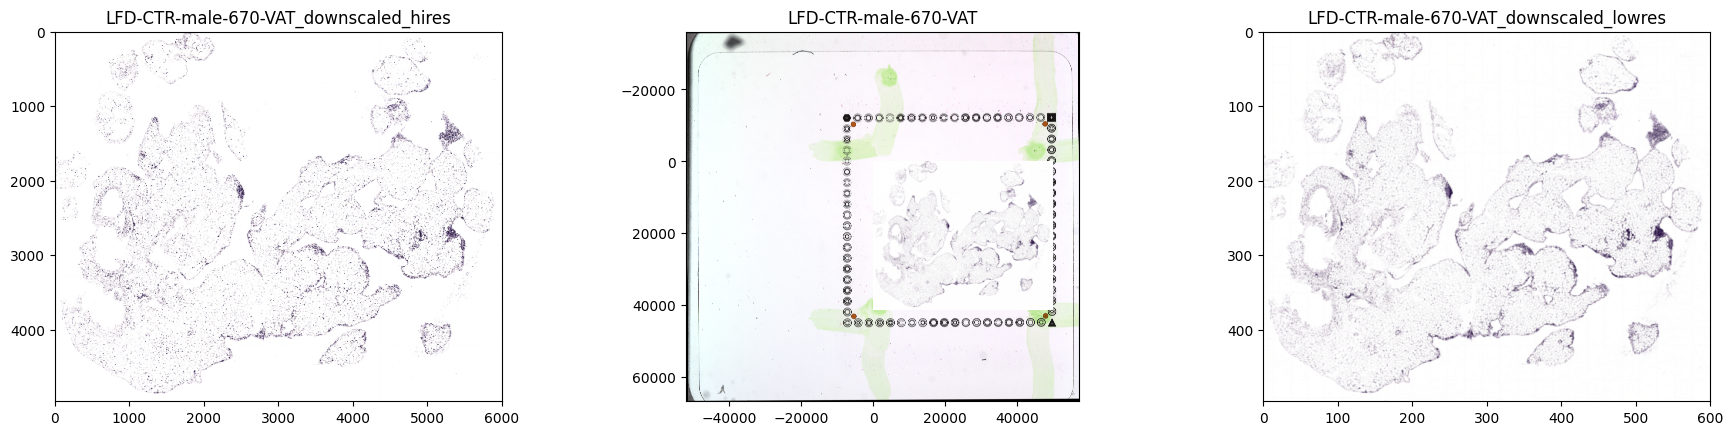

In [ ]:
%%time

from spatialdata_io import visium_hd
import spatialdata_plot as sdp
from spatialdata import get_extent, bounding_box_query, rasterize_bins
from spatialdata_plot.pl.utils import set_zero_in_cmap_to_transparent


def GetSpatialData(
    directory: str,
    savedir: str,
    intermediate_path: str = "outs",
    max_n=None,
    overwrite=True,
    **kwargs
):
    """
    Gets all spatial data from a directory.
    **kwargs are sent to `spatialdata_io.visium_hd()`
    """
    sdatas = {}
    barcodes = {}
    samples = os.listdir(directory)
    samples = samples[:max_n]

    for n, sample in tqdm(enumerate(samples)):
        print(sample)

        savefile = os.path.join(savedir, sample, "object.zarr")

        if overwrite is True:
            sdata = visium_hd(
                os.path.join(directory, sample, intermediate_path),
                dataset_id=sample,
                load_all_images=True,
                var_names_make_unique=True,
            )
            sdata.write(savefile, overwrite=overwrite, **kwargs)

        sdata = sd.read_zarr(savefile)
        for table in sdata.tables.values():
            table.obs["Identifier"] = sample
            table.layers["counts"] = table.X

        sdatas[sample] = sdata

        spatial_barcode_subsets = os.listdir(os.path.join(savedir, sample))
        barcodes[sample] = {}
        for csv in spatial_barcode_subsets:
            if ".csv" in csv:
                barcodes[sample][csv] = pd.read_csv(os.path.join(savedir, sample, csv))

    return samples, sdatas, barcodes


samples, sdatas, barcodes = GetSpatialData(
    os.path.join(DATADIR, "spaceranger", "LM13969"),
    os.path.join(DATADIR, "processed", "raws"),
    overwrite=False,
)
samples = samples[1:]

sample = samples[0]
sdata = sdatas[sample]
sdata.pl.render_images().pl.show()

sdata

INFO     Rasterizing image for faster rendering.                                                                   


INFO     Rasterizing image for faster rendering.                                                                   


INFO     Rasterizing image for faster rendering.                                                                   


CPU times: user 11.8 s, sys: 2.84 s, total: 14.7 s
Wall time: 14.7 s


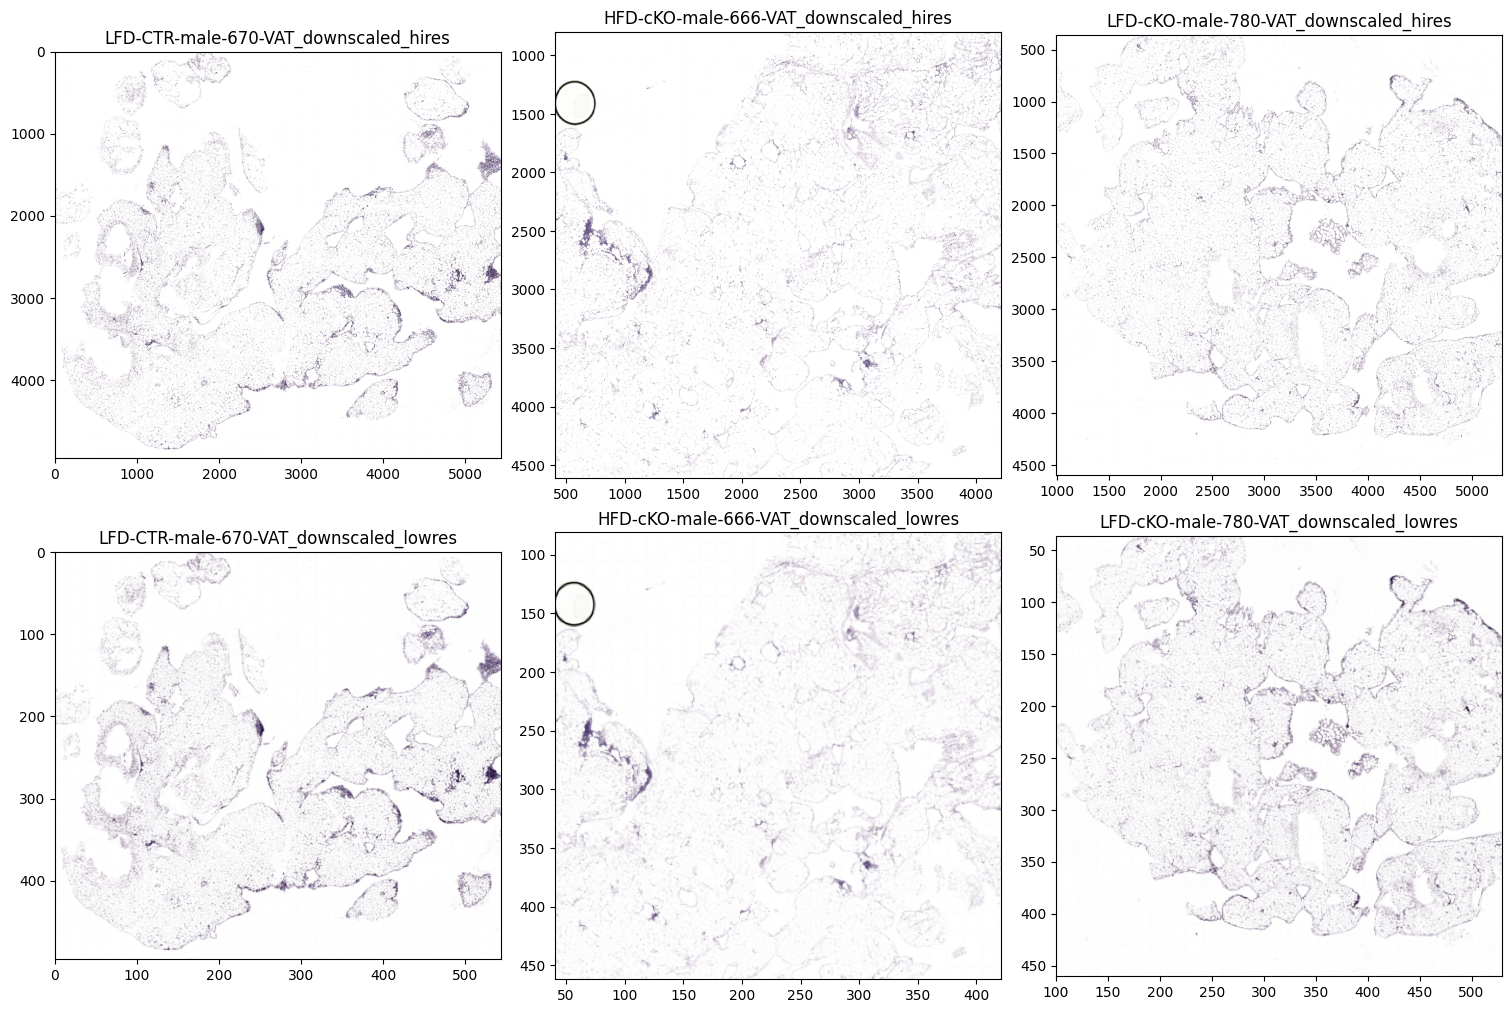

In [ ]:
%%time
# get aligned hires

f, axs = plt.subplots(
    2, len(samples), figsize=(len(samples) * 5, 10), layout="constrained"
)
for i, samp in enumerate(samples):
    data_extent = {}

    mins = np.min(sdatas[samp].tables["square_016um"].obsm["spatial"], axis=0)
    maxs = np.max(sdatas[samp].tables["square_016um"].obsm["spatial"], axis=0)
    data_extent["x"] = (mins[0], maxs[0])
    data_extent["y"] = (mins[1], maxs[1])

    queried_img = bounding_box_query(
        sdatas[samp][f"{samples[i]}_hires_image"],
        min_coordinate=[data_extent["x"][0], data_extent["y"][0]],
        max_coordinate=[data_extent["x"][1], data_extent["y"][1]],
        axes=("x", "y"),
        target_coordinate_system=samp,
    )
    sdatas[samp]["queried_hires"] = queried_img
    sdatas[samp].pl.render_images("queried_hires").pl.show(
        coordinate_systems=f"{samp}_downscaled_hires", ax=axs[0][i]
    )

    queried_img = bounding_box_query(
        sdatas[samp][f"{samples[i]}_lowres_image"],
        min_coordinate=[data_extent["x"][0], data_extent["y"][0]],
        max_coordinate=[data_extent["x"][1], data_extent["y"][1]],
        axes=("x", "y"),
        target_coordinate_system=samp,
    )
    sdatas[samp]["queried_lowres"] = queried_img
    sdatas[samp].pl.render_images("queried_lowres").pl.show(
        coordinate_systems=f"{samp}_downscaled_lowres", ax=axs[1][i]
    )

In [ ]:
for n, samp in enumerate(samples):
    for bin_size in ["016", "008", "002"]:
        sdatas[samp][f"square_{bin_size}um"].X = sdatas[samp][
            f"square_{bin_size}um"
        ].X.tocsc()
        rasterized = rasterize_bins(
            sdatas[samp],
            f"{samp}_square_{bin_size}um",
            f"square_{bin_size}um",
            "array_col",
            "array_row",
        )
        sdatas[samp][f"rasterized_008um"] = rasterized

### Sample Plot

In [ ]:
gene_name = "Adgre1"
trans_cmap = set_zero_in_cmap_to_transparent(cmap="Reds")

f, axs = plt.subplots(1, 2, figsize=(10, 5), layout="constrained")
sdata.pl.render_images(
    "rasterized_016um", channel=gene_name, scale="full", cmap=trans_cmap
).pl.show(
    coordinate_systems=sample,
    ax=axs[0],
)

sdata.pl.render_images(f"{sample}_lowres_image", scale="full").pl.show(
    coordinate_systems=sample,
    ax=axs[1],
)

In [ ]:
sdata_small = sdatas[sample].query.bounding_box(
    min_coordinate=[22000, 27000],
    max_coordinate=[25000, 35000],
    axes=("x", "y"),
    target_coordinate_system=sample,
)

gene_name = "Adgre1"
trans_cmap = set_zero_in_cmap_to_transparent(cmap="Reds")

f, axs = plt.subplots(1, 2, figsize=(10, 5), layout="constrained")
sdata_small.pl.render_images(
    "rasterized_016um", channel=gene_name, scale="full", cmap=trans_cmap
).pl.show(
    coordinate_systems=sample,
    ax=axs[0],
)

sdata_small.pl.render_images(f"{sample}_lowres_image", scale="full").pl.show(
    coordinate_systems=sample,
    ax=axs[1],
)

# Initial Clustering

### QC

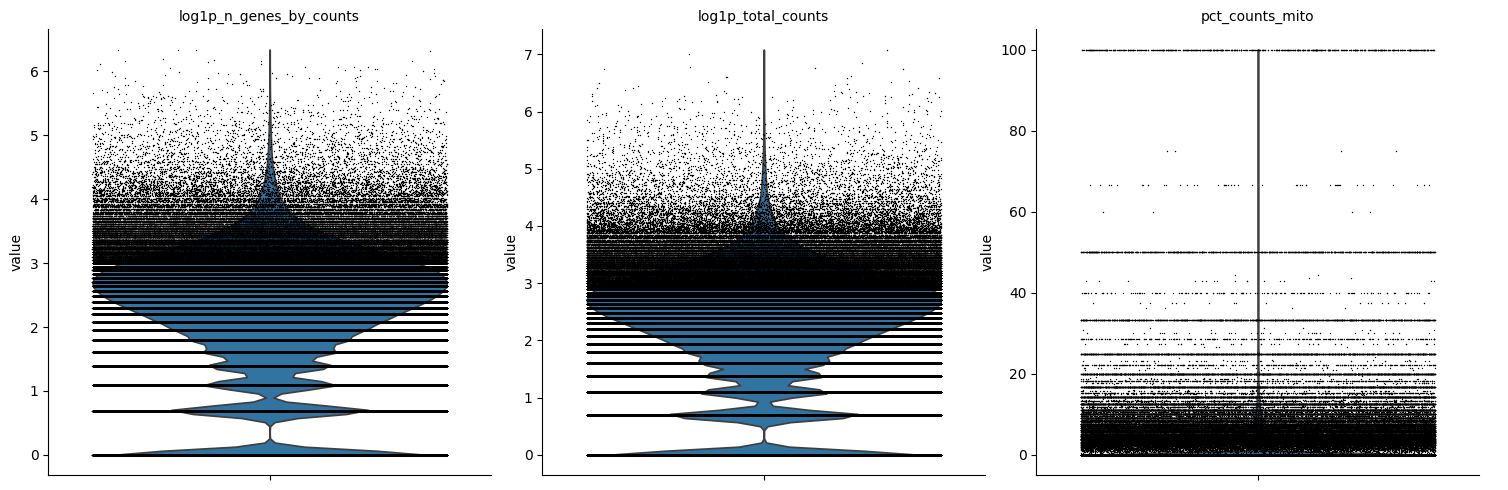

(0.0, 40.0)

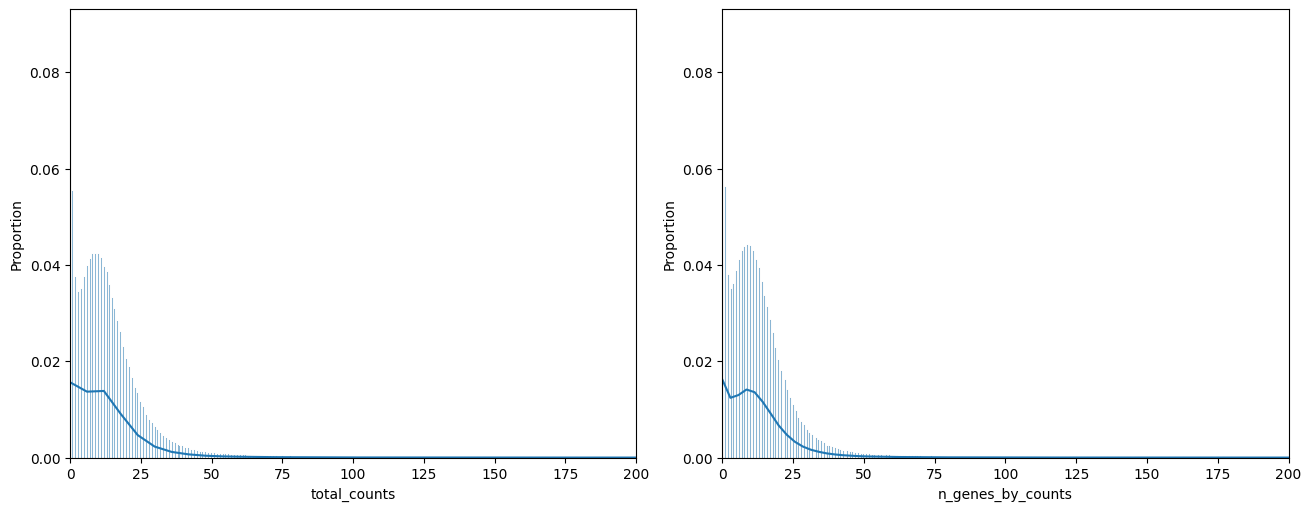

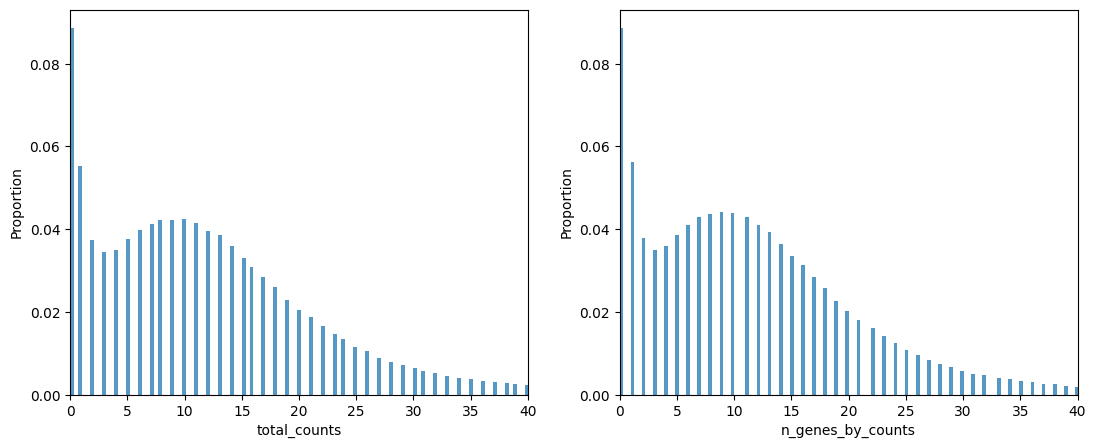

In [ ]:
adata = sdatas[samp].tables["square_008um"].copy()

# calculated QCs
sc.pp.calculate_qc_metrics(adata, inplace=True, percent_top=[20])
Filter_GeneGroup(adata)

# plot QCs
sc.pl.violin(
    adata,
    ["log1p_n_genes_by_counts", "log1p_total_counts", "pct_counts_mito"],
    jitter=0.4,
    multi_panel=True,
)

f, axs = plt.subplots(1, 2, figsize=(13, 5), layout="constrained")
sns.histplot(
    adata.obs["total_counts"],
    kde=True,
    ax=axs[0],
    stat="proportion",
    # log_scale=True,
)
axs[0].set_xlim(0, 200)

sns.histplot(
    adata.obs["n_genes_by_counts"],
    kde=True,
    ax=axs[1],
    stat="proportion",
    # log_scale=True,
)
axs[1].set_xlim(0, 200)

f, axs = plt.subplots(1, 2, figsize=(13, 5))
sns.histplot(adata.obs["total_counts"], ax=axs[0], stat="proportion")
axs[0].set_xlim(0, 40)
sns.histplot(adata.obs["n_genes_by_counts"], ax=axs[1], stat="proportion")
axs[1].set_xlim(0, 40)

CPU times: user 2.46 s, sys: 79.9 ms, total: 2.54 s
Wall time: 2.53 s


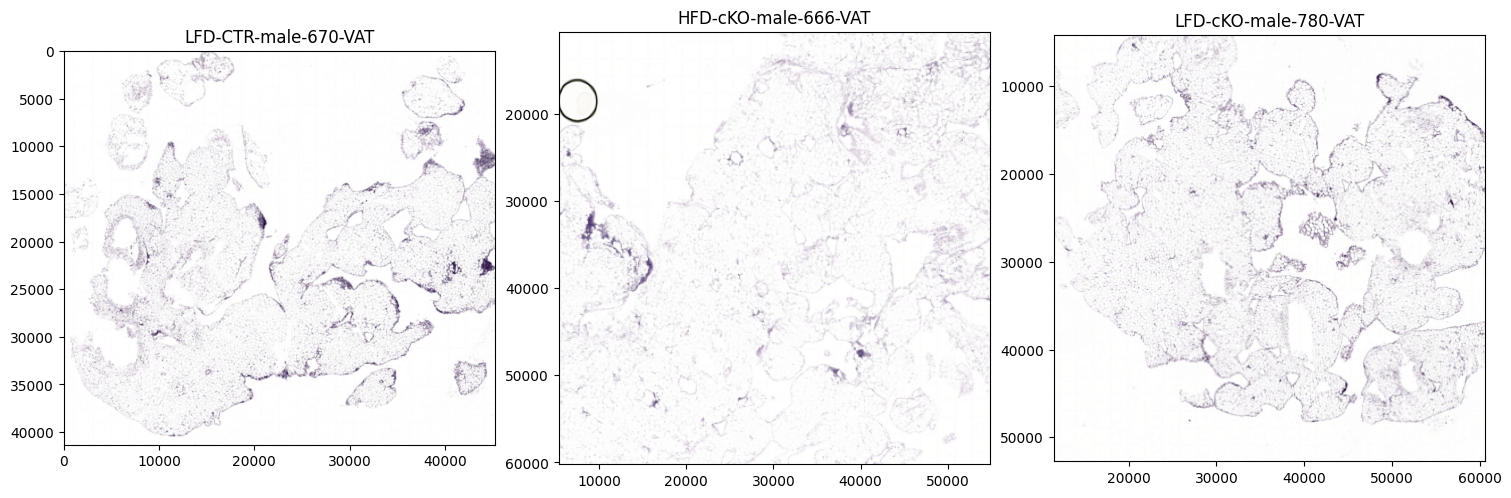

In [ ]:
%%time

# View images
f, axs = plt.subplots(
    1, len(samples), figsize=(len(samples) * 5, 5), layout="constrained"
)
for i, samp in enumerate(samples):
    sdatas[samp].pl.render_images("queried_lowres").pl.show(
        coordinate_systems=samp, ax=axs[i]
    )

In [ ]:
# add adata metadata

for s in samples:
    adata = sdatas[s].tables["square_008um"]
    adata.obs["whole_tissue"] = adata.obs_names.isin(
        barcodes[s]["EH whole tissue.csv"].Barcode
    )
    adata.obs["cluster_cleaned"] = adata.obs_names.isin(
        barcodes[s]["JB autocluster.csv"].Barcode
    )

    idents = adata.obs["Identifier"].str.split("-|_", expand=True)
    adata.obs["Diet"] = idents[0]
    adata.obs["Model"] = idents[1]
    adata.obs["Group"] = adata.obs["Diet"] + "-" + adata.obs["Model"]
    adata.layers["counts"] = adata.X

sdatas[samples[0]].tables["square_008um"].obs.head(10)

in_tissue  array_row  array_col  location_id  \
s_008um_00269_00526-1          1        269        526            0   
s_008um_00260_00253-1          1        260        253            1   
s_008um_00433_00599-1          1        433        599            2   
s_008um_00819_00322-1          1        819        322            3   
s_008um_00266_00304-1          1        266        304            4   
s_008um_00154_00449-1          1        154        449            5   
s_008um_00359_00037-1          1        359         37            6   
s_008um_00469_00254-1          1        469        254            7   
s_008um_00674_00375-1          1        674        375            8   
s_008um_00226_00670-1          1        226        670            9   

                                                  region  \
s_008um_00269_00526-1  LFD-CTR-male-670-VAT_square_008um   
s_008um_00260_00253-1  LFD-CTR-male-670-VAT_square_008um   
s_008um_00433_00599-1  LFD-CTR-male-670-VAT_square_008um   
s_008um_00819_00322-1  LFD-CTR-male-670-VAT_square_008um   
s_008um_00266_00304-1  LFD-CTR-male-670-VAT_square_008um   
s_008um_00154_00449-1  LFD-CTR-male-670-VAT_square_008um   
s_008um_00359_00037-1  LFD-CTR-male-670-VAT_square_008um   
s_008um_00469_00254-1  LFD-CTR-male-670-VAT_square_008um   
s_008um_00674_00375-1  LFD-CTR-male-670-VAT_square_008um   
s_008um_00226_00670-1  LFD-CTR-male-670-VAT_square_008um   

                                 Identifier  whole_tissue  cluster_cleaned  \
s_008um_00269_00526-1  LFD-CTR-male-670-VAT         False            False   
s_008um_00260_00253-1  LFD-CTR-male-670-VAT         False            False   
s_008um_00433_00599-1  LFD-CTR-male-670-VAT          True            False   
s_008um_00819_00322-1  LFD-CTR-male-670-VAT         False            False   
s_008um_00266_00304-1  LFD-CTR-male-670-VAT         False            False   
s_008um_00154_00449-1  LFD-CTR-male-670-VAT         False            False   
s_008um_00359_00037-1  LFD-CTR-male-670-VAT         False            False   
s_008um_00469_00254-1  LFD-CTR-male-670-VAT          True             True   
s_008um_00674_00375-1  LFD-CTR-male-670-VAT         False            False   
s_008um_00226_00670-1  LFD-CTR-male-670-VAT         False            False   

                      Diet Model    Group  
s_008um_00269_00526-1  LFD   CTR  LFD-CTR  
s_008um_00260_00253-1  LFD   CTR  LFD-CTR  
s_008um_00433_00599-1  LFD   CTR  LFD-CTR  
s_008um_00819_00322-1  LFD   CTR  LFD-CTR  
s_008um_00266_00304-1  LFD   CTR  LFD-CTR  
s_008um_00154_00449-1  LFD   CTR  LFD-CTR  
s_008um_00359_00037-1  LFD   CTR  LFD-CTR  
s_008um_00469_00254-1  LFD   CTR  LFD-CTR  
s_008um_00674_00375-1  LFD   CTR  LFD-CTR  
s_008um_00226_00670-1  LFD   CTR  LFD-CTR

In [ ]:
# subset for whole tissue
for s in samples:
    adata = sdatas[s]["square_008um"]
    sdatas[s]["square_008um"] = adata[adata.obs["whole_tissue"]]

INFO     Using 'datashader' backend with 'None' as reduction method to speed up plotting. Depending on the         
         reduction method, the value range of the plot might change. Set method to 'matplotlib' do disable this    
         behaviour.                                                                                                
INFO     Using the datashader reduction "mean". "max" will give an output very close to the matplotlib result.     
INFO     Using 'datashader' backend with 'None' as reduction method to speed up plotting. Depending on the         
         reduction method, the value range of the plot might change. Set method to 'matplotlib' do disable this    
         behaviour.                                                                                                
INFO     Using the datashader reduction "mean". "max" will give an output very close to the matplotlib result.     
INFO     Using 'datashader' backend with 'None' as reduction method to s

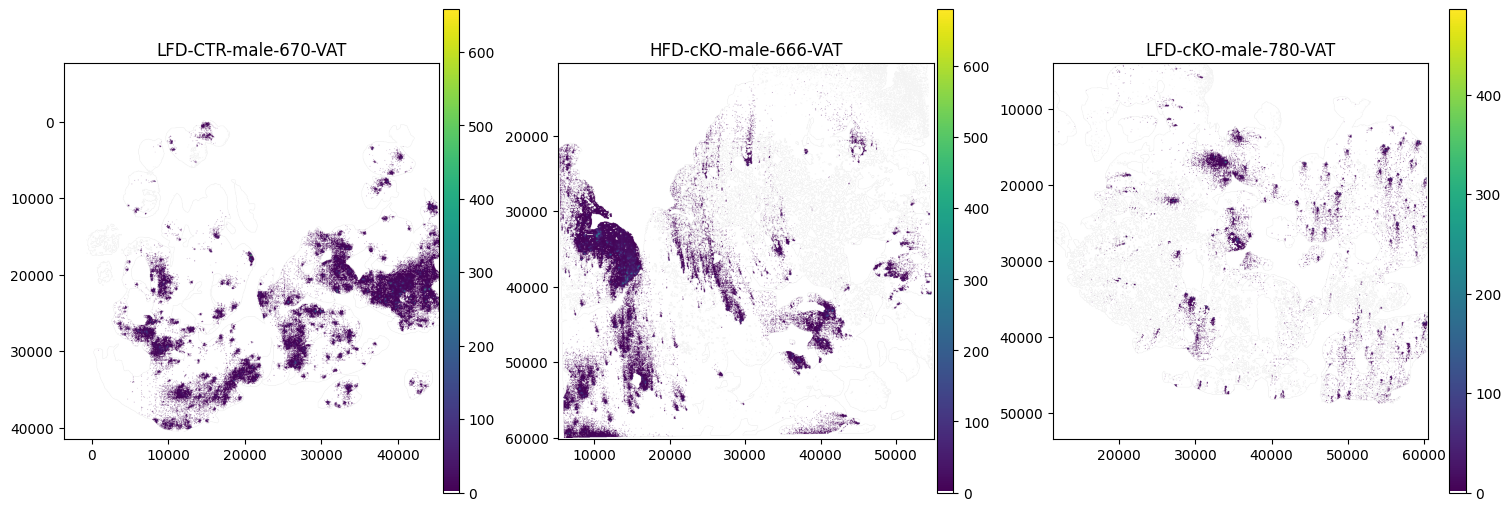

In [ ]:
%%time
gene_name = "Igkc"

new_cmap = set_zero_in_cmap_to_transparent(cmap="viridis")

f, axs = plt.subplots(
    1, len(samples), figsize=(len(samples) * 5, 5), layout="constrained"
)
for i, samp in enumerate(samples):
    sdatas[samp].pl.render_shapes(
        f"{samp}_square_008um",
        color=gene_name,
        cmap=new_cmap,
    ).pl.show(coordinate_systems=samp, ax=axs[i])

In [ ]:
runFilters = True

filters = {"GenesPerCell": 30, "ReadsPerCell": 0, "CellsPerGene": 10, "Mito%": 15}

for i, samp in enumerate(samples):
    adata = sdatas[samp]["square_008um"]

    if runFilters is True:
        Filter_QC(
            adata,
            GenePerCell=filters["GenesPerCell"],
            CountPerCell=filters["ReadsPerCell"],
            CellPerGene=filters["CellsPerGene"],
            verbose=True,
        )
        Filter_GeneGroup(
            adata,
            key="mito",
            marker="mt",
            verbose=True,
            perc_threshold=filters["Mito%"],
        )

Cells removed by gene/count filters: 2
Cells with >15% mito genes: 36
Cells removed by gene/count filters: 5
Cells with >15% mito genes: 9
Cells removed by gene/count filters: 33
Cells with >15% mito genes: 6


INFO     Rasterizing image for faster rendering.                                                                   


INFO     Using 'datashader' backend with 'None' as reduction method to speed up plotting. Depending on the         
         reduction method, the value range of the plot might change. Set method to 'matplotlib' do disable this    
         behaviour.                                                                                                
INFO     Using the datashader reduction "mean". "max" will give an output very close to the matplotlib result.     
INFO     Rasterizing image for faster rendering.                                                                   


INFO     Using 'datashader' backend with 'None' as reduction method to speed up plotting. Depending on the         
         reduction method, the value range of the plot might change. Set method to 'matplotlib' do disable this    
         behaviour.                                                                                                
INFO     Using the datashader reduction "mean". "max" will give an output very close to the matplotlib result.     
INFO     Rasterizing image for faster rendering.                                                                   


INFO     Using 'datashader' backend with 'None' as reduction method to speed up plotting. Depending on the         
         reduction method, the value range of the plot might change. Set method to 'matplotlib' do disable this    
         behaviour.                                                                                                
INFO     Using the datashader reduction "mean". "max" will give an output very close to the matplotlib result.     


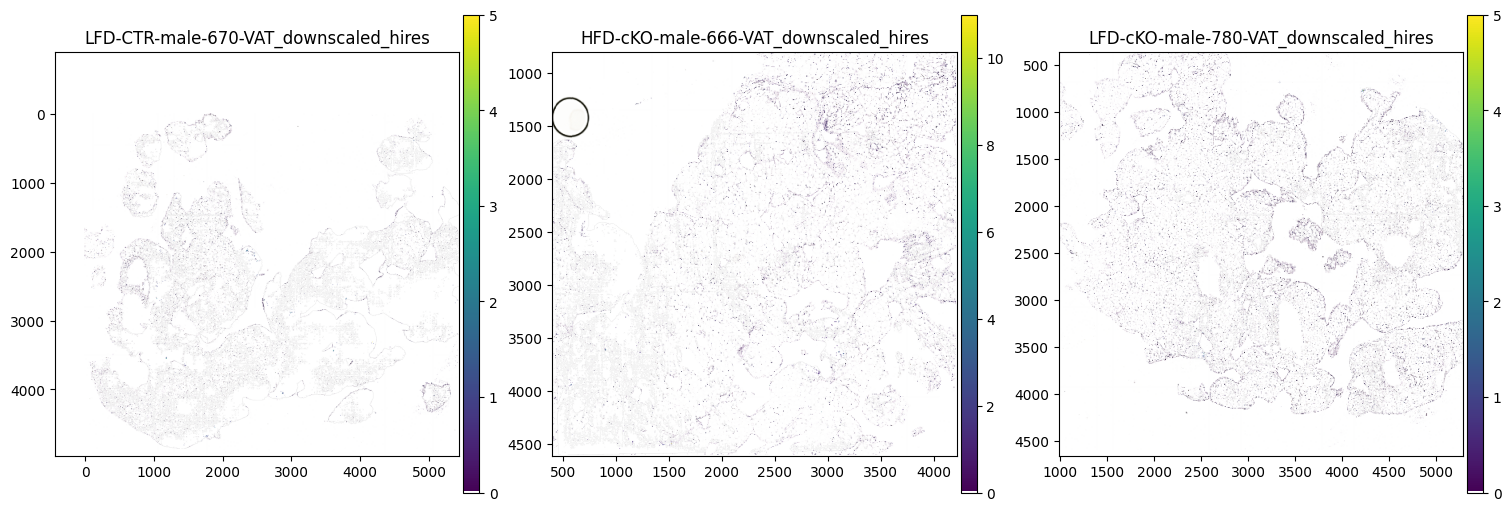

In [ ]:
# plot target genes upon images
f, axs = plt.subplots(
    1, len(samples), figsize=(len(samples) * 5, 5), layout="constrained"
)

for i, samp in enumerate(samples):
    sdatas[samp].pl.render_images("queried_hires").pl.render_shapes(
        f"{samp}_square_008um",
        color="Cma1",
        cmap=new_cmap,
    ).pl.show(coordinate_systems=f"{samp}_downscaled_hires", ax=axs[i])

In [ ]:
# Filter out annoying IgG genes

for samp in samples:
    adata = sdatas[samp]["square_008um"]
    sdatas[samp]["square_008um"] = adata[
        :, adata.var_names.str.contains("Igh|Igk|Jchain") == 0
    ]

filters = {"GenesPerCell": 75, "ReadsPerCell": 0, "CellsPerGene": 10, "Mito%": 15}

for i, samp in enumerate(samples):
    adata = sdatas[samp]["square_008um"]

    if runFilters is True:
        Filter_QC(
            adata,
            GenePerCell=filters["GenesPerCell"],
            CountPerCell=filters["ReadsPerCell"],
            CellPerGene=filters["CellsPerGene"],
            verbose=True,
        )
        Filter_GeneGroup(
            adata,
            key="mito",
            marker="mt",
            verbose=True,
            perc_threshold=filters["Mito%"],
        )

    print(adata)

Cells removed by gene/count filters: 36078
Cells with >15% mito genes: 0
AnnData object with n_obs × n_vars = 30800 × 12693
    obs: 'in_tissue', 'array_row', 'array_col', 'location_id', 'region', 'Identifier', 'whole_tissue', 'cluster_cleaned', 'Diet', 'Model', 'Group', 'n_genes', 'n_counts', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'pct_counts_mito'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mito', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'spatialdata_attrs'
    obsm: 'spatial'
    layers: 'counts'
Cells removed by gene/count filters: 17612
Cells with >15% mito genes: 0
AnnData object with n_obs × n_vars = 16908 × 11866
    obs: 'in_tissue', 'array_row', 'array_col', 'location_id', 'region', 'Identifier', 'whole_tissue', 'cluster_cleaned', 'Diet', 'Model', 'Group', 'n_genes', 'n_counts', 'n_genes_by_counts',

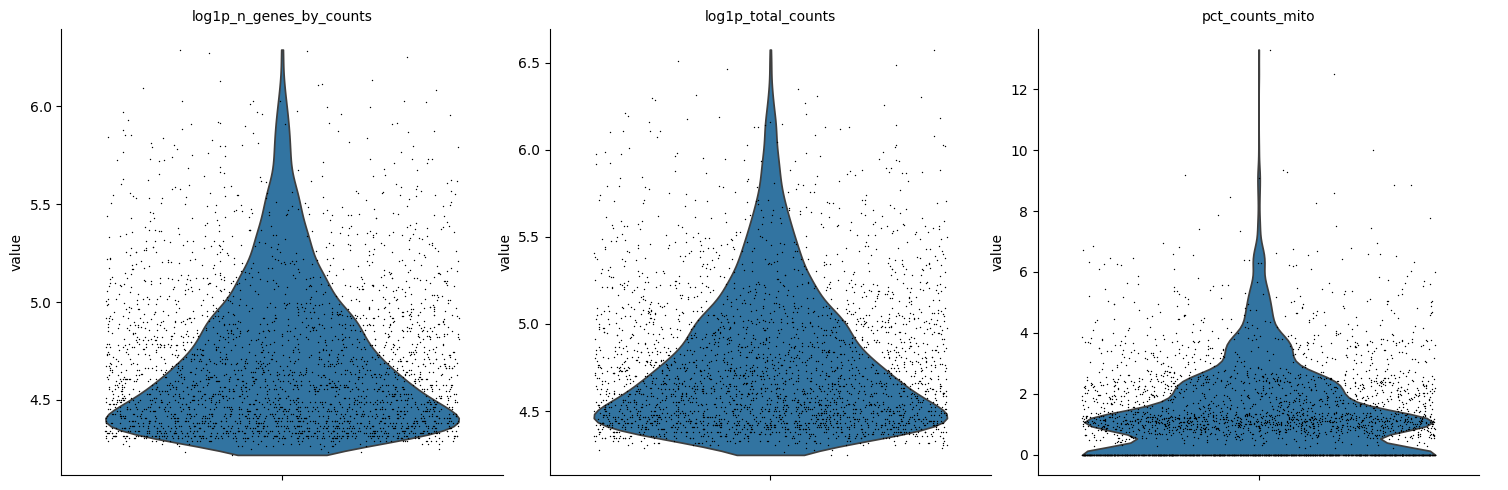

(0.0, 200.0)

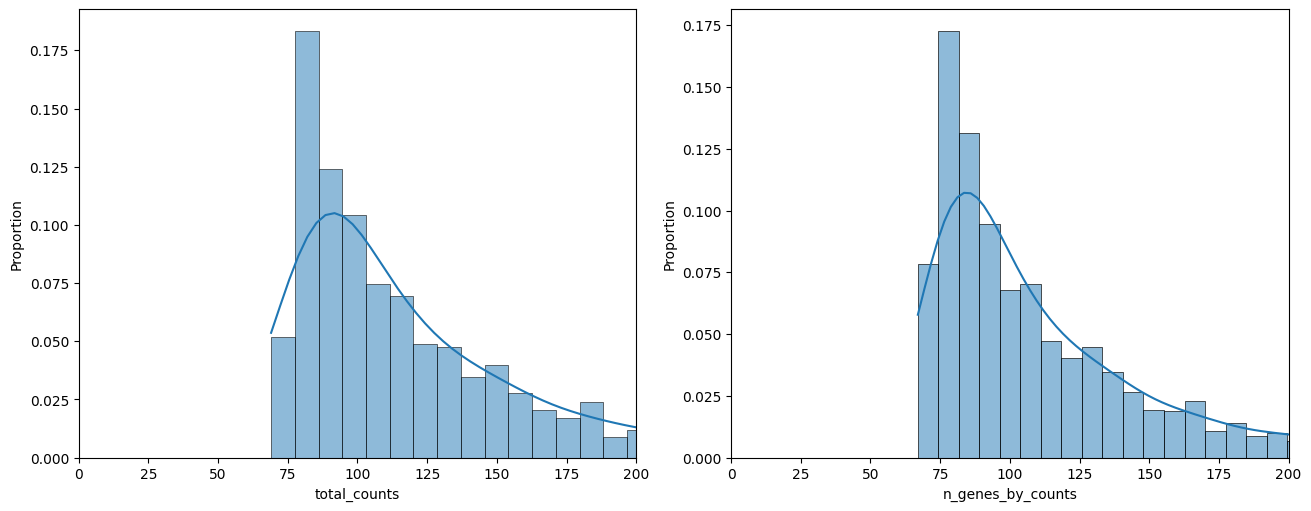

In [ ]:
# QC check 2
adata = sdatas[samp].tables["square_008um"].copy()

# calculated QCs
sc.pp.calculate_qc_metrics(adata, inplace=True, percent_top=[20])
Filter_GeneGroup(adata)

# plot QCs
sc.pl.violin(
    adata,
    ["log1p_n_genes_by_counts", "log1p_total_counts", "pct_counts_mito"],
    jitter=0.4,
    multi_panel=True,
)

f, axs = plt.subplots(1, 2, figsize=(13, 5), layout="constrained")
sns.histplot(
    adata.obs["total_counts"],
    kde=True,
    ax=axs[0],
    stat="proportion",
    # log_scale=True,
)
axs[0].set_xlim(0, 200)

sns.histplot(
    adata.obs["n_genes_by_counts"],
    kde=True,
    ax=axs[1],
    stat="proportion",
    # log_scale=True,
)
axs[1].set_xlim(0, 200)

Saving normalized counts in layer 'normalized'.
Finding HVGs...


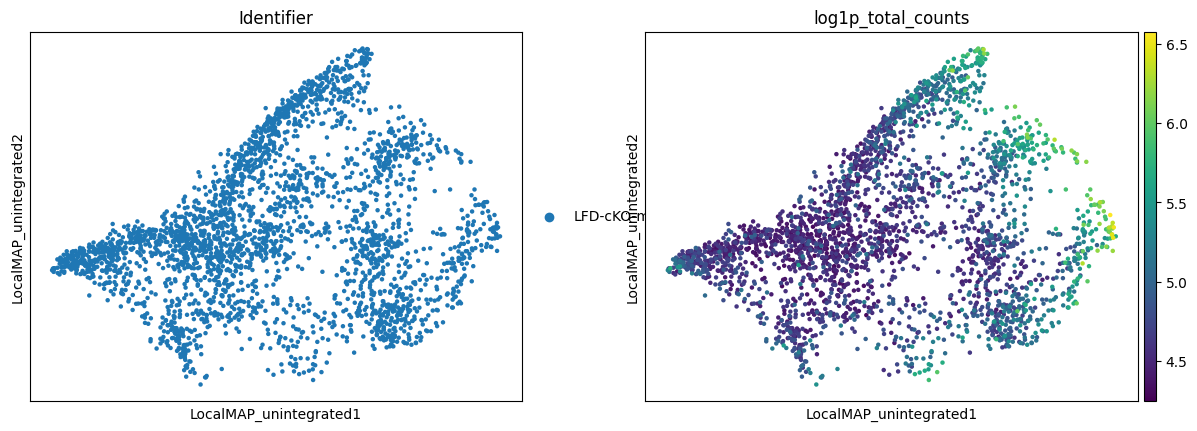

KeyError: "Could not find 'UMAP_unintegrated' or 'X_UMAP_unintegrated' in .obsm"

In [ ]:
adata_unInt = sc.concat(
    [sdatas[samp]["square_008um"] for samp in samples],
    join="outer",
)
adata_unInt.uns["QC filters"] = filters


# order categories
order_obs(adata_unInt, "Diet", ["LFD", "HFD"])
order_obs(adata_unInt, "Model", ["CTR", "cKO"])
order_obs(adata_unInt, "Group", ["LFD-CTR", "LFD-cKO", "HFD-cKO"])

Normalize(adata_unInt, kind="log1p")
FindVariableGenes(
    adata_unInt, kind="seurat_v3", batch_column="Identifier", n_features=100
)

from pacmap import LocalMAP

sc.pp.neighbors(adata_unInt)
sc.tl.umap(adata_unInt, key_added=f"UMAP_unintegrated")
lm = LocalMAP()
adata.obsm[f"LocalMAP_unintegrated"] = lm.fit_transform(adata.X.toarray())

plotting = ["Identifier", "log1p_total_counts"]
sc.pl.embedding(adata, "LocalMAP_unintegrated", color=plotting)
sc.pl.embedding(adata, "UMAP_unintegrated", color=plotting)

### Integration

In [ ]:
batch_column = "Identifier"
hvg_kind = "seurat_v3"
int_kind = "harmony"

# adata_FULL = sc.concat(
#     [sdatas[samp]["square_008um"].copy() for samp in samples], join="outer"
# )
# adata_FULL.uns["QC filters"] = filters

adata_FULL_WT = sc.concat(
    [sdatas[samp]["square_008um"] for samp in samples],
    join="outer",
)
adata_FULL_WT.uns["QC filters"] = filters


# order categories
order_obs(adata_FULL_WT, "Diet", ["LFD", "HFD"])
order_obs(adata_FULL_WT, "Model", ["CTR", "cKO"])
order_obs(adata_FULL_WT, "Group", ["LFD-CTR", "LFD-cKO", "HFD-cKO"])

Normalize(adata_FULL_WT, kind="log1p")
FindVariableGenes(
    adata_FULL_WT, kind=hvg_kind, batch_column=batch_column, n_features=100
)
print(adata_FULL_WT.var_names[adata_FULL_WT.var["highly_variable"]].to_list(), "\n")
Integrate(adata_FULL_WT, kind=int_kind, batch_column=batch_column, use_var_genes=False)
Visualize(adata_FULL_WT)

Saving normalized counts in layer 'normalized'.
Finding HVGs...
['Adam8', 'Ankrd6', 'Arg1', 'Arrdc3', 'Cacnb3', 'Ccl19', 'Ccl21a', 'Ccl22', 'Ccl5', 'Cd5l', 'Cd7', 'Cd74', 'Cd79a', 'Cd79b', 'Ceacam16', 'Clec9a', 'Cma1', 'Col3a1', 'Coro1a', 'Ctsl', 'Ctss', 'Cxcl13', 'Cxcl2', 'Cxcl9', 'Eln', 'Fbn1', 'Fbxl12', 'Fcna', 'Fmo1', 'Fn1', 'Gbp2b', 'Glipr2', 'Gpnmb', 'Gzma', 'H2-Aa', 'H2-Ab1', 'H2-Eb1', 'H2ac24', 'Hba-a2', 'Hbb-bs', 'Hbb-bt', 'Id4', 'Iglc1', 'Iglc2', 'Iglc3', 'Il1rn', 'Il4i1', 'Klhl14', 'Lgals3', 'Lrrc32', 'Mamdc2', 'Marco', 'Mcpt4', 'Mgp', 'Mki67', 'Mmp12', 'Mmp19', 'Mmp25', 'Mmp9', 'Mzb1', 'Napg', 'Nnat', 'Oaf', 'Oaz2', 'Pdk4', 'Penk', 'Pi16', 'Plekhg6', 'Plin4', 'Pnpla3', 'Prg4', 'Qrsl1', 'Retnla', 'Rgs1', 'Rnf128', 'Rnf24', 'Rrm2', 'S100a8', 'S100a9', 'Saa3', 'Scarf2', 'Sel1l3', 'Sell', 'Serpine2', 'Slc7a10', 'Slpi', 'Spp1', 'Tagln', 'Tbc1d19', 'Timp1', 'Tm4sf19', 'Tpsb2', 'Trbv20', 'Trbv3', 'Txndc5', 'Ugt3a2', 'Vsig4', 'Wnt6', 'Xcl1', 'Ythdc1'] 

Integrating by Column Identi

2025-08-13 16:53:50,166 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...
2025-08-13 16:54:11,070 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-08-13 16:54:11,375 - harmonypy - INFO - Iteration 1 of 50
INFO:harmonypy:Iteration 1 of 50
2025-08-13 16:54:34,337 - harmonypy - INFO - Iteration 2 of 50
INFO:harmonypy:Iteration 2 of 50
2025-08-13 16:54:55,468 - harmonypy - INFO - Iteration 3 of 50
INFO:harmonypy:Iteration 3 of 50
2025-08-13 16:55:16,660 - harmonypy - INFO - Iteration 4 of 50
INFO:harmonypy:Iteration 4 of 50
2025-08-13 16:55:38,031 - harmonypy - INFO - Iteration 5 of 50
INFO:harmonypy:Iteration 5 of 50
2025-08-13 16:55:49,126 - harmonypy - INFO - Iteration 6 of 50
INFO:harmonypy:Iteration 6 of 50
2025-08-13 16:55:56,923 - harmonypy - INFO - Iteration 7 of 50
INFO:harmonypy:Iteration 7 of 50
2025-08-13 16:56:04,690 - 

Starting UMAP...
Starting LocalMAP...


AnnData object with n_obs × n_vars = 50619 × 12758
    obs: 'in_tissue', 'array_row', 'array_col', 'location_id', 'region', 'Identifier', 'whole_tissue', 'cluster_cleaned', 'Diet', 'Model', 'Group', 'n_genes', 'n_counts', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'pct_counts_mito'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'QC filters', 'methods', 'log1p', 'hvg', 'pca', 'neighbors', 'UMAP'
    obsm: 'spatial', 'X_pca', 'integrated', 'UMAP', 'LocalMAP'
    varm: 'PCs'
    layers: 'counts', 'normalized'
    obsp: 'distances', 'connectivities'

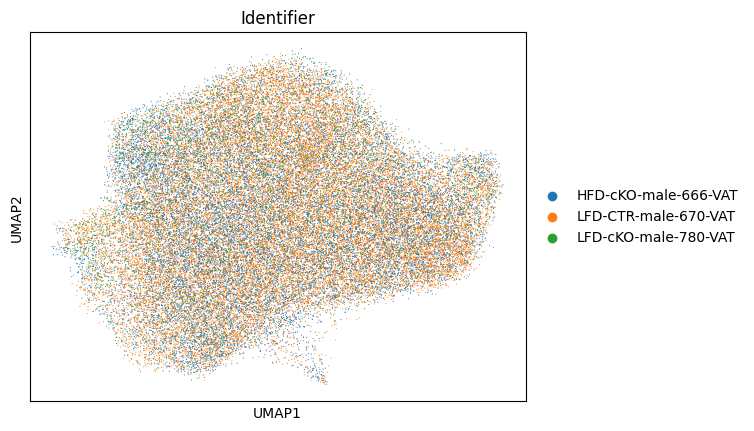

In [ ]:
sc.pl.embedding(adata_FULL_WT, basis="UMAP", color="Identifier")

### Cluster

In [ ]:
%%time
res = 1
cluster_key = f"leiden_{res:.1f}"
print(cluster_key)
sc.tl.leiden(adata_FULL_WT, resolution=res, key_added=cluster_key)

leiden_1.0
CPU times: user 1min 32s, sys: 276 ms, total: 1min 33s
Wall time: 1min 32s


CPU times: user 53.4 s, sys: 144 ms, total: 53.5 s
Wall time: 5.16 s


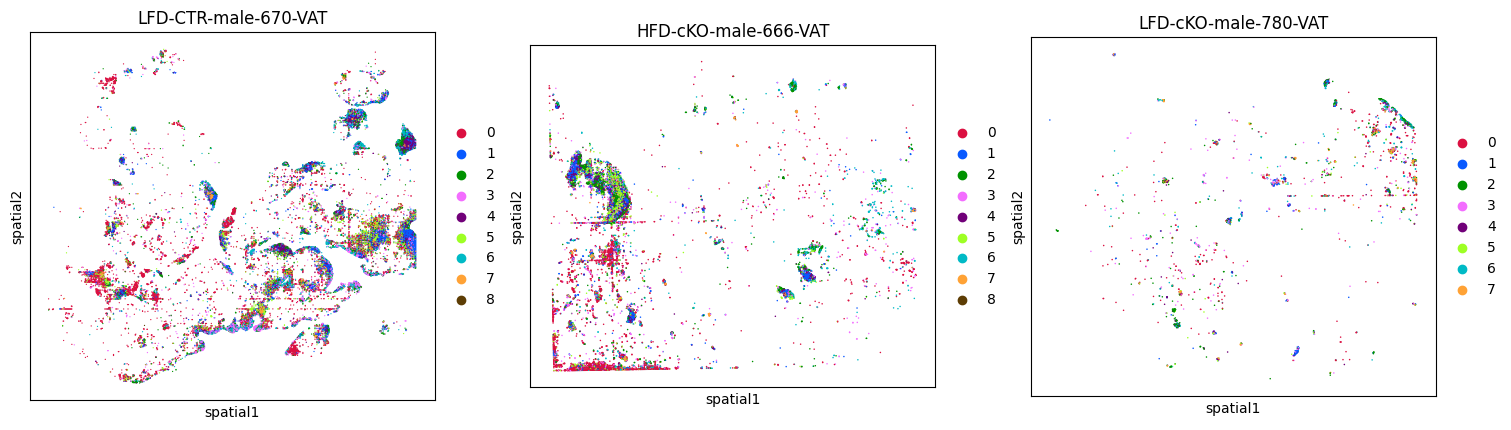

In [ ]:
%%time
res = 1
cluster_key = f"leiden_{res:.1f}"

f, axs = plt.subplots(
    1, len(samples), figsize=(len(samples) * 5, 5), layout="constrained"
)
for n, id in enumerate(adata_FULL_WT.obs["Identifier"].unique()):
    sc.pl.spatial(
        adata_FULL_WT[adata_FULL_WT.obs["Identifier"] == id],
        color=cluster_key,
        spot_size=150 if n == 0 else 200,
        ax=axs[n],
        show=False,
        palette=color_gen(adata_FULL_WT.obs[cluster_key].unique()).to_list(),
        title=id,
    )

In [3]:
# SAVE
# adata_FULL_WT.write(
#     os.path.join(DATADIR, "processed", "combined", "raw_processed-V5 WT_filter75.h5ad")
# )
# LOAD
adata_FULL_WT = sc.read_h5ad(
    os.path.join(DATADIR, "processed", "combined", "raw_processed-V5 WT_filter75.h5ad")
)

### Visualize

<Axes: title={'center': 'Model'}, xlabel='UMAP1', ylabel='UMAP2'>

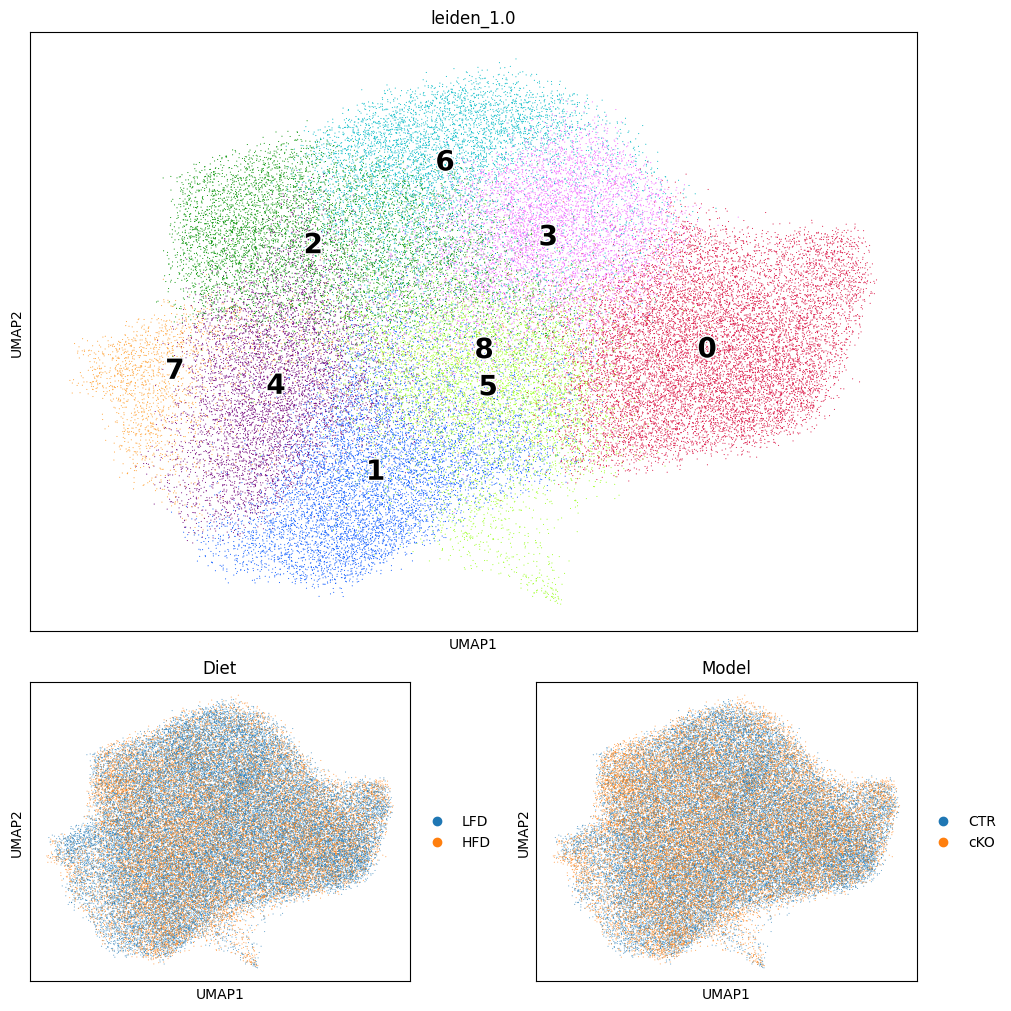

In [4]:
res = 1
cluster_key = f"leiden_{res:.1f}"
embedding = "UMAP"

cluster_c = color_gen(adata_FULL_WT.obs[cluster_key])
f = plt.figure(figsize=(10, 10), layout="constrained")

axs = f.subplots(3, 2)
gs = axs[0, 0].get_gridspec()
for rs in axs[:]:
    for ax in rs[:]:
        ax.remove()

# Large LocalMAP plot
ax = f.add_subplot(gs[:2, :])
sc.pl.embedding(
    adata_FULL_WT,
    basis=embedding,
    color=[cluster_key],
    ax=ax,
    show=False,
    legend_loc="on data",
    legend_fontoutline=2,
    legend_fontsize=20,
    palette=cluster_c.to_list(),
)
# ax = f.add_subplot(gs[2, 0])
# sc.pl.embedding(
#     adata_FULL_WT,
#     basis=embedding,
#     color=["Group"],
#     ax=ax,
#     show=False,
#     alpha=0.7,
# )
ax = f.add_subplot(gs[2, 0])
sc.pl.embedding(
    adata_FULL_WT, basis=embedding, color=["Diet"], ax=ax, show=False, alpha=0.7
)
ax = f.add_subplot(gs[2, 1])
sc.pl.embedding(
    adata_FULL_WT, basis=embedding, color=["Model"], ax=ax, show=False, alpha=0.7
)

In [5]:
variable_genes = (
    adata_FULL_WT.var[adata_FULL_WT.var["highly_variable"]].sort_values(
        "highly_variable_rank"
    )
).index
variable_genes

Index(['Iglc1', 'Gpnmb', 'Hbb-bs', 'Hba-a2', 'Mmp12', 'Iglc2', 'Cma1', 'Slpi',
       'Xcl1', 'Mcpt4', 'Marco', 'Mmp9', 'Mmp19', 'Retnla', 'Tpsb2', 'Mki67',
       'Gzma', 'Fn1', 'Saa3', 'Tagln', 'Lgals3', 'Iglc3', 'Ccl21a', 'Txndc5',
       'Ugt3a2', 'Hbb-bt', 'Cd74', 'H2ac24', 'Cxcl2', 'Scarf2', 'Ceacam16',
       'S100a8', 'Cd5l', 'Pnpla3', 'Timp1', 'Plin4', 'Sel1l3', 'Ctsl',
       'Ankrd6', 'H2-Aa', 'Oaz2', 'Mgp', 'H2-Eb1', 'Eln', 'Rnf24', 'Tbc1d19',
       'Cxcl13', 'Slc7a10', 'Arrdc3', 'Cd79b', 'S100a9', 'Il1rn', 'Lrrc32',
       'Plekhg6', 'Glipr2', 'Ctss', 'Trbv3', 'Cxcl9', 'Id4', 'Fcna', 'Cd79a',
       'Napg', 'Mmp25', 'Nnat', 'Spp1', 'Penk', 'Pi16', 'Arg1', 'Mzb1',
       'H2-Ab1', 'Fbn1', 'Rnf128', 'Pdk4', 'Il4i1', 'Ccl5', 'Fbxl12', 'Adam8',
       'Rrm2', 'Mamdc2', 'Gbp2b', 'Col3a1', 'Fmo1', 'Wnt6', 'Rgs1', 'Vsig4',
       'Coro1a', 'Cacnb3', 'Ccl19', 'Tm4sf19', 'Ythdc1', 'Trbv20', 'Prg4',
       'Ccl22', 'Clec9a', 'Cd7', 'Serpine2', 'Sell', 'Klhl14', 'Oaf', 'Qrsl1'],
   

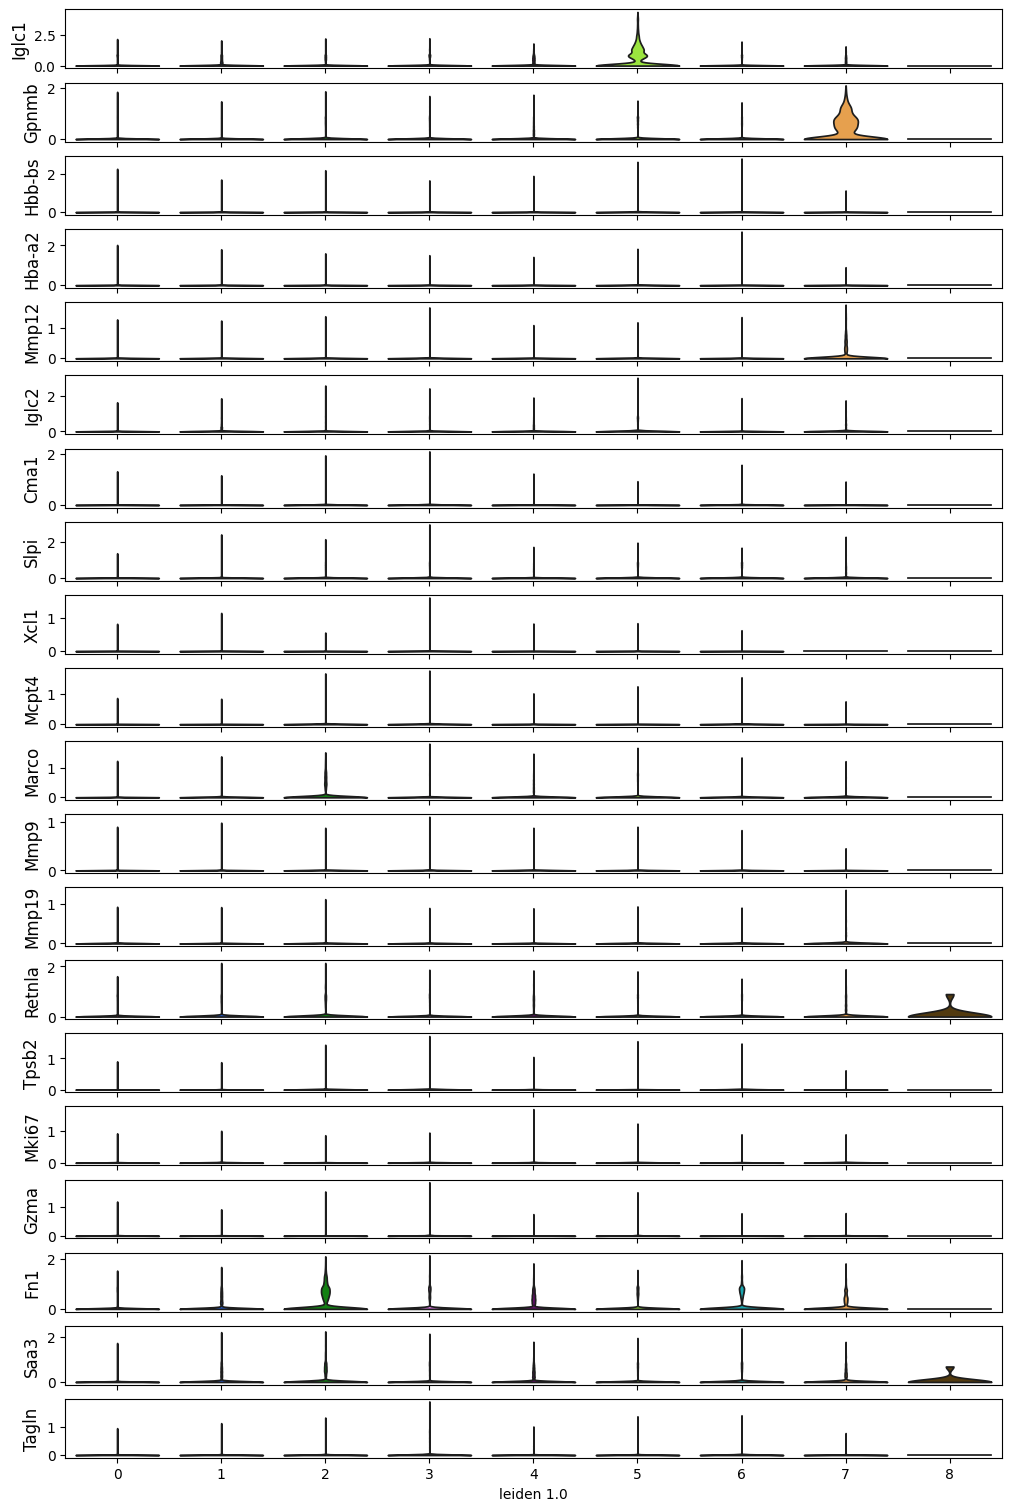

In [20]:
def plot_violinplot(
    adata,
    markers,
    group: str,
    f,
    layer: str = "normalized",
    useStripPlot=True,
    bracket_params=None,
):
    axs = f.subplots(len(markers), 1)
    for n, m in enumerate(markers):
        sc.pl.violin(
            adata,
            m,
            groupby=group,
            use_raw=False,
            layer=layer,
            show=False,
            ax=axs[n],
            stripplot=useStripPlot,
        )
        if n < len(markers) - 1:
            axs[n].set_xlabel("")
            axs[n].set_xticklabels([""] * len(axs[n].get_xticklabels()))
        axs[n].set_ylabel(axs[n].get_ylabel(), size=12)

    if bracket_params is not None:
        ratios = bracket_params["ratio"] / np.sum(bracket_params["ratio"])
        ends = np.append(0, np.cumsum(ratios))
        bar_label_locs = [ends[i] + ratios[i] / 2 for i in range(len(ratios))]
        bar_bracket_widths = ratios * f.get_size_inches()[0] * 3.1

        axs = f.get_axes()
        for (
            n,
            label,
        ) in enumerate(bracket_params["labels"]):
            axs[-1].annotate(
                label,
                xy=(bar_label_locs[n], -bracket_params["bracket_y"]),
                xytext=(bar_label_locs[n], -bracket_params["label_y"]),
                xycoords="axes fraction",
                ha="center",
                va="bottom",
                bbox=dict(boxstyle="square", fc="none", color="none"),
                arrowprops=dict(
                    arrowstyle=f"-[, widthB={bar_bracket_widths[n]}, lengthB=0.3",
                    lw=1.0,
                    color="k",
                ),
            )
        axs[-1].set_xlabel(axs[-1].get_xlabel(), labelpad=bracket_params["padding"])

    return


f = plt.figure(figsize=(10, 15), layout="constrained")

# markers = [
#     "Adipoq",
#     "Pdgfra",
#     "Upk3b",
#     "Cdh5",
#     "Rgs5",
#     "Adgre1",
#     "Flt3",
#     "Cpa3",
#     "Skap1",
#     "Igkc",
# ]
plot_violinplot(
    adata_FULL_WT,
    variable_genes[:20],
    cluster_key,
    f,
    useStripPlot=False,
    layer="normalized",
)

In [7]:
sc.tl.rank_genes_groups(
    adata_FULL_WT,
    groupby=cluster_key,
    key_added=f"de_{cluster_key}",
    use_raw=False,
    layer="normalized",
    method="wilcoxon",
)

dendrogram data not found (using key=dendrogram_leiden_1.0). Running `sc.tl.dendrogram` with default parameters. For fine tuning it is recommended to run `sc.tl.dendrogram` independently.


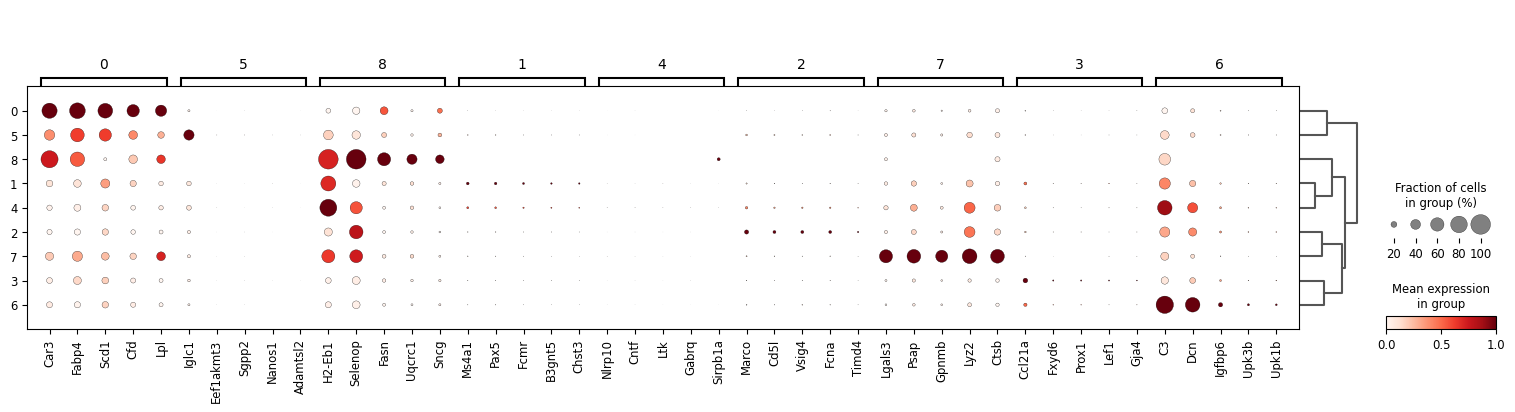

In [8]:
sc.pl.rank_genes_groups_dotplot(
    adata_FULL_WT,
    groupby=cluster_key,
    key=f"de_{cluster_key}",
    standard_scale="var",
    n_genes=5,
    min_logfoldchange=2,
)

47


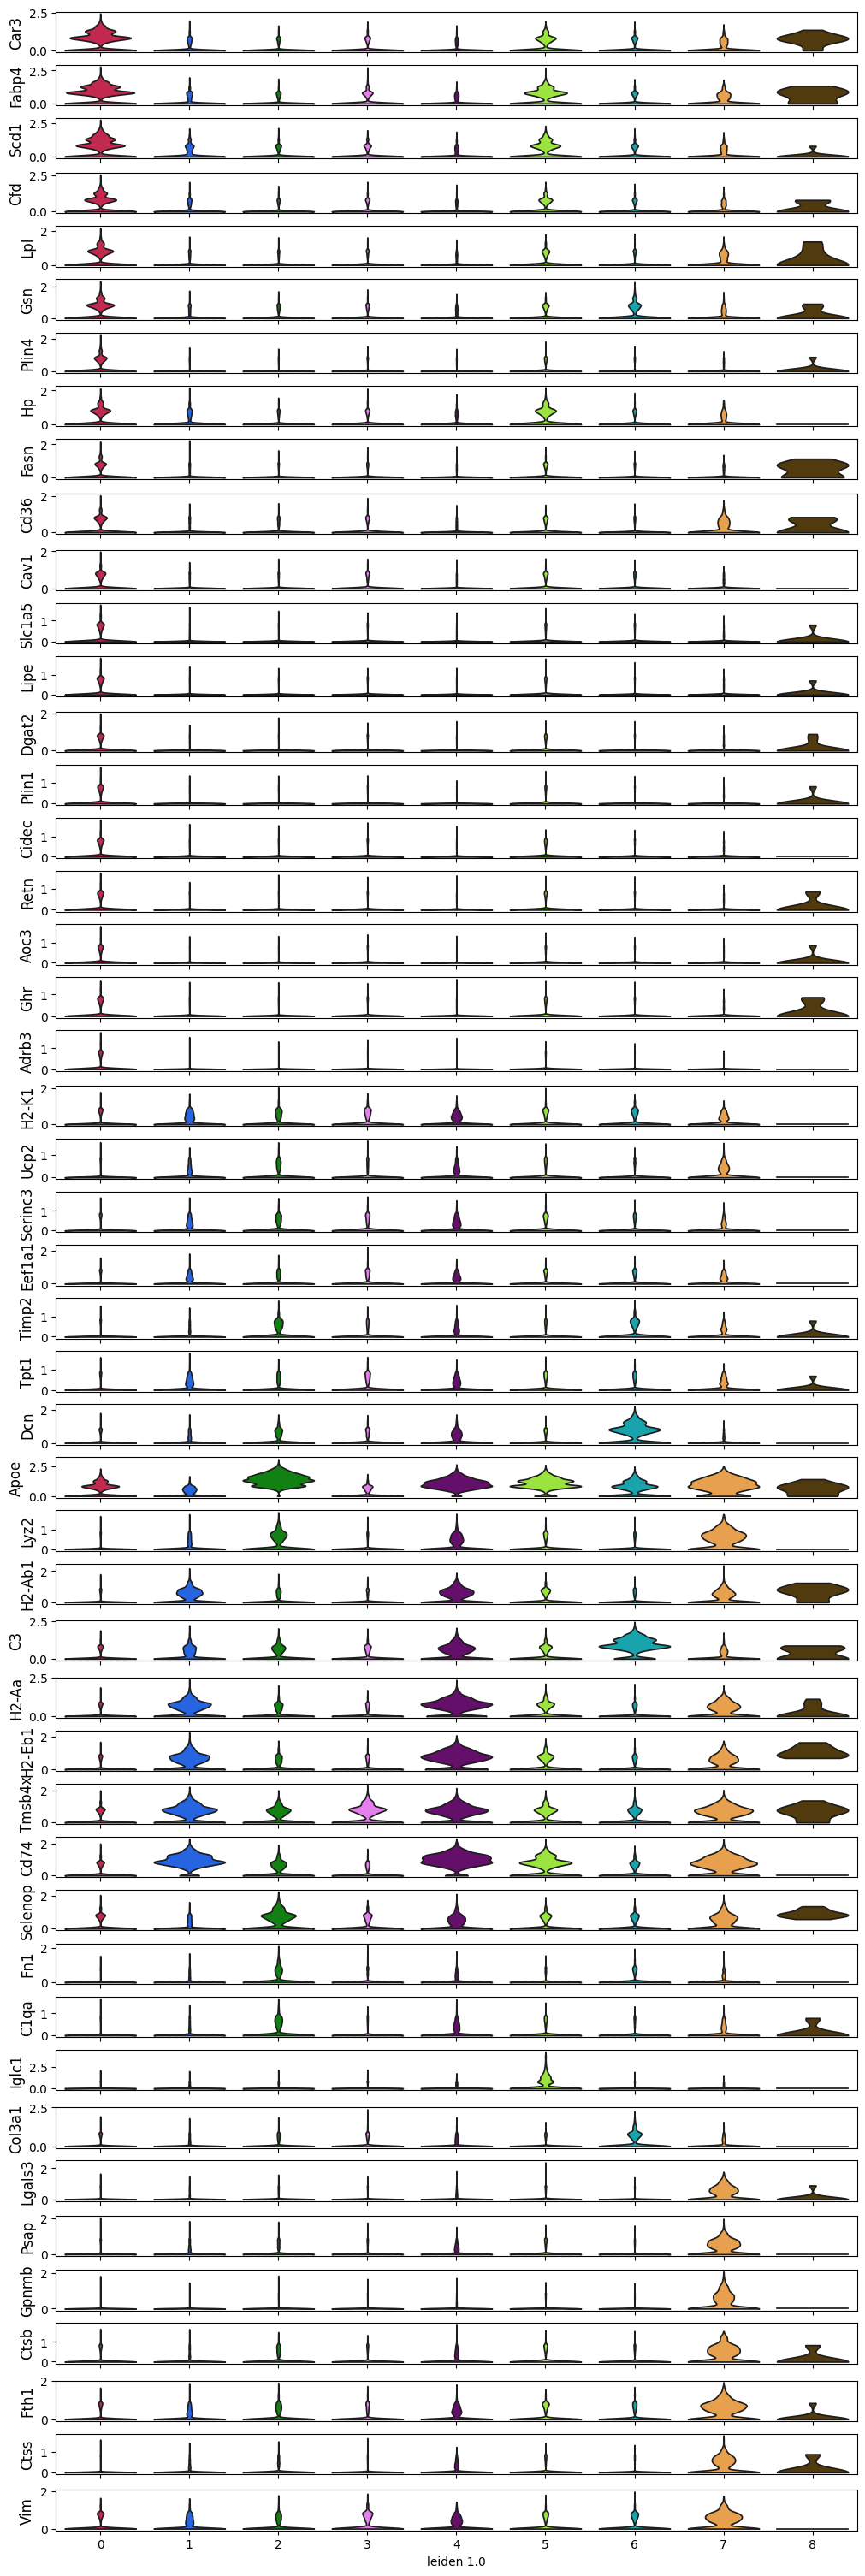

In [18]:
df = sc.get.rank_genes_groups_df(adata_FULL_WT, group=None, key=f"de_{cluster_key}")
DEGs_1e100 = df[df["pvals_adj"] < 1e-100].names.unique()
print(len(DEGs_1e100))

f = plt.figure(figsize=(10, 30), layout="constrained")
plot_violinplot(
    adata_FULL_WT,
    DEGs_1e100,
    cluster_key,
    f,
    useStripPlot=False,
    layer="normalized",
)

In [21]:
# SAVE
adata_FULL_WT.write(
    os.path.join(DATADIR, "processed", "combined", "raw_processed-V5 WT_filter75.h5ad")
)
# LOAD
adata_FULL_WT = sc.read_h5ad(
    os.path.join(DATADIR, "processed", "combined", "raw_processed-V5 WT_filter75.h5ad")
)